**Model description:**

As latent variables, we have decided to use ones which deffer for different data points.

* $T$ - the left-upper pixels of villain's face images.
* $\Theta= (B,V,\epsilon)$, B - background picture, V - villain's face image, $\epsilon$ - noise parameter.
* $X$ - noisy data.

Params:

* H= 110
* W= 163
* K = 400
* h = 96
* w = 75



Let's introduce the next model:


$$p(x_i|t_j, \Theta) =\prod_{pixel \in [t_j,t_j+(h-1,w-1)]}N(x_{i_{pixel}} - V_{pixel-t_j}|0,\epsilon^2)\prod_{pixel \notin [t_j,t_j+(h-1,w-1)]}N(x_{i_{pixel}} - B_{pixel}|0,\epsilon^2)$$


Therefore, $p(x_i|t_j, \Theta) = N(x_i|\mu(t_j,\Theta),\Sigma(t_j,\Theta))$

Let's introduce new variables to sumplify our EM formulas:

$z_i \in \{0,1\}: \forall i  \in (H-h+1)\times(W-w+1) \, \sum_iz_i=1$

**E-step:**


$$q(t_j,x_i) = q_i(t_j) = p(t_j|x_i,\Theta) = \frac{p(x_i|t_j,\Theta)p(t_j|\theta)}{\sum_jp(x_i|t_j,\Theta)p(t_j|\theta)} $$

Here, we suppose the following (but we actually can tune it too):

$$p(t_j|\theta) = p(t_j) = \frac{1}{(H-h+1)(W-w+1)}$ $

**M-step:**

$$E_qlog(p(X,T|\Theta)) -> max_{\Theta}$$

$$E_qlog(p(X,T|\Theta)) = E_qlog(\prod_i\prod_jp(x_i,t_j|\Theta)) = E_qlog(\prod_i\prod_jp(x_i|t_j,\Theta)p(t_j|\Theta)) =
E_q(log(\prod_i\prod_jp(x_i|t_j,\Theta) + log(\prod_jp(t_j|\Theta)))$$

$$E_q(log(\prod_i\prod_jp(x_i|t_j,\Theta) + log(\prod_jp(t_j)) -> max_{\Theta}$$

$$E_qlog(\prod_i\prod_jp(x_i|t_j,\Theta) -> max_{\Theta}$$

$$\sum_i\sum_jq_i(t_j)p(x_i|t_j,\Theta) -> max_{\Theta}$$

$$\sum_i\sum_jq_i(t_j)N(x_i|\mu(t_j,\Theta),\Sigma(t_j,\Theta)) -> max_{\Theta=(B,V,\epsilon)}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import copy
% matplotlib inline

In [2]:
data = np.load('CameraData.npy')

In [3]:
data.shape

(110, 163, 400)

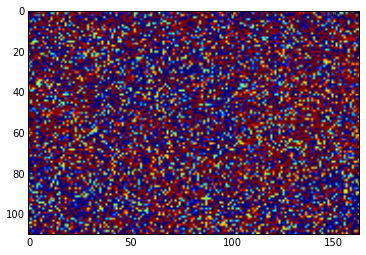

In [4]:
plt.imshow(data[:,:,7])

In [17]:
sps.uniform.rvs?


In [18]:
class ImageDetector():
    
    def __init__(self, H, W, h, w):
        self.H = H
        self.W = W
        self.h = h
        self.w = w
        
        
    def fit(self, X, tolerance=0.001, max_iter=50, restart=10):
       
        F_opt = None
        B_opt = None
        s_opt = None
        A_opt = None
        LL_opt = [-np.inf]
        self.N = X.shape[2]

        for i in range(restart):
            F, B, s, LL = self.EM(X, tolerance=tolerance, max_iter=max_iter)

            if LL[-1] > LL_opt[-1]:
                F_opt, B_opt, s_opt, LL_opt = F, B, s, LL
                
        return F_opt, B_opt, s_opt, LL_opt
    
    
    def EM(self, X, F=None, B=None, s=None, A=None, tolerance=0.001, max_iter=50):
      
        F = sps.randint.rvs(size=(self.h, self.w), low=0, high=256)       
        B = sps.randint.rvs(size=(self.H, self.W), low=0, high=256)    
        
        A = sps.uniform.rvs(size=(self.H - self.h + 1, self.W - self.w + 1))
        A = A / np.sum(A)
        
        s = sps.uniform.rvs(size=1, loc=0, scale=100)


        lpx_d_all = self.lpxt_theta(X, F, B, s)
        LL = []

        for n_iter in range(max_iter):
            
            # E-step
            q = self.e_step(X, F, B, s, A, lpx_d_all=lpx_d_all)
            
            # M-step
            F, B, s = self.m_step(X, q)
                
            # Calculate Variational Lower Bound
            lpx_d_all = self.lpxt_theta(X, F, B, s)
            LL.append(self.VLB(X, F, B, s, A, q, lpx_d_all))

            # Check stop criterion
            if n_iter > 0 and np.abs(LL[-1] - LL[-2]) < tolerance:
                break

        return F, B, s, LL
 
    

    def VLB(self, X, F, B, s, A, q, lpxt_theta_v=None):
      
        if lpxt_theta_v is None:
            lpxt_theta_v = self.lpxt_theta(X, F, B, s)
            
        L = 0
        for k in range(lpxt_theta_v.shape[2]):
            L += lpxt_theta_v[q[0, k], q[1, k], k] + np.log(A[q[0, k], q[1, k]])

        return L
    
    
    def lpxt_theta(self, X, F, B, s):
        

        L = np.zeros((self.H - self.h + 1, self.W - self.w + 1, self.N))
        X = X.transpose([2, 0, 1])

        # some constants for normal distribution for fast work
        const_add = -self.h * self.w * np.log(2 * np.pi * s ** 2) / 2
        const_mult = -1. / (2 * s ** 2)

        # cumulative sums for calculating sums in O(1)
        logpdf_B = -np.log(2 * np.pi * s ** 2) / 2 + const_mult * (X - B) ** 2
        cumsum_logpdf_B = np.cumsum(np.cumsum(logpdf_B, axis=1), axis=2)
        cumsum_logpdf_B = cumsum_logpdf_B.transpose([1, 2, 0])

        for dh in range(self.H - self.h + 1):
            for dw in range(self.W - self.w + 1):
                logpdf_F = ((X[:, dh:dh + self.h, dw:dw + self.w] - F) ** 2).sum(axis=(1, 2))
                L[dh, dw] = cumsum_logpdf_B[-1, -1] - cumsum_logpdf_B[dh + self.h - 1, dw + self.w - 1] \
                             + const_add + const_mult * logpdf_F
                if dh > 0:
                    L[dh, dw] += cumsum_logpdf_B[dh - 1, dw + self.w - 1]
                if dw > 0:
                    L[dh, dw] += cumsum_logpdf_B[dh + self.h - 1, dw - 1]
                if dh > 0 and dw > 0:
                    L[dh, dw] -= cumsum_logpdf_B[dh - 1, dw - 1]
        return L



    def e_step(self, X, F, B, s, A, lpx_d_all):


        lpx_d_all = lpx_d_all.transpose([2, 0, 1])

        alpha = (lpx_d_all + np.log(A)).transpose([1, 2, 0])
        alpha = alpha - alpha.max(axis=(0, 1))  # for more robust normalization
        alpha = np.exp(alpha)
        q = alpha / alpha.sum(axis=(0, 1))


        q_ = np.zeros((2, self.N))
        for k in range(self.N):
            index = q[:, :, k].argmax()
            q_[0, k] = index / (self.W - self.w + 1)
            q_[1, k] = index % (self.W - self.w + 1)
        return q_

    
    #####################
    def m_step_F(self, X, q):
        
        
        F = np.zeros((self.h, self.w))
        for k in range(self.N):
            dh, dw = q[0, k], q[1, k]
            F += X[dh:dh + self.h, dw:dw + self.w, k]
        F = F / self.N

        return F


    def m_step_B(self, X, q):

        B = X.sum(axis=2)
        Z = np.ones((self.H, self.W)) * self.N
        for k in range(self.N):
            dh, dw = q[0, k], q[1, k]
            B[dh:dh + self.h, dw:dw + self.w] -= X[dh:dh + self.h, dw:dw + self.w, k]
            Z[dh:dh + self.h, dw:dw + self.w] -= 1

        B = B / Z

        B = np.nan_to_num(B)

        return B


    def m_step_s(self, X, q, F, B):

        L = np.zeros((self.H - self.h + 1, self.W - self.w + 1, self.N))
        X = X.transpose([2, 0, 1])

        dif_B = (X - B) ** 2
        cumsum_dif_B = np.cumsum(np.cumsum(dif_B, axis=1), axis=2)
        cumsum_dif_B = cumsum_dif_B.transpose([1, 2, 0])


        for k in np.arange(self.N):
            dh, dw = q[0, k], q[1, k]
            dif_F = ((X[k, dh:dh + self.h, dw:dw + self.w] - F) ** 2).sum()
            cur_dif_B = copy.deepcopy(cumsum_dif_B[dh + self.h - 1, dw + self.w - 1, k])
            if dh > 0:
                cur_dif_B -= cumsum_dif_B[dh - 1, dw + self.w - 1, k]
            if dw > 0:
                cur_dif_B -= cumsum_dif_B[dh + self.h - 1, dw - 1, k]
            if dh > 0 and dw > 0:
                cur_dif_B += cumsum_dif_B[dh - 1, dw - 1, k]

            L[dh, dw, k] = dif_F - cur_dif_B

        L = np.nan_to_num(L - L * 0)
        s_sq = (np.sum(L) + np.sum(cumsum_dif_B[-1, -1])) / (self.H * self.W * self.N)

        return np.sqrt(s_sq)
    
    ######################
    
    def m_step(self, X, q):
  
        F = self.m_step_F(X, q)
        B = self.m_step_B(X, q)
        s = self.m_step_s(X, q, F, B)

        return F, B, s

In [19]:
H, W, _ = data.shape
det = ImageDetector(H, W, 96, 75)
result = det.fit(data, max_iter=10, restart=1)

/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:129: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:141: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:142: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:163: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:164: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Arseny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16

In [12]:
result[3]

[-44252562.9084206,
 -44245865.670397498,
 -44228581.720372073,
 -44218912.015137352,
 -44216397.900244944,
 -44215510.226151638,
 -44215128.085953012,
 -44214859.033634871,
 -44214814.328040056,
 -44214792.659133084]

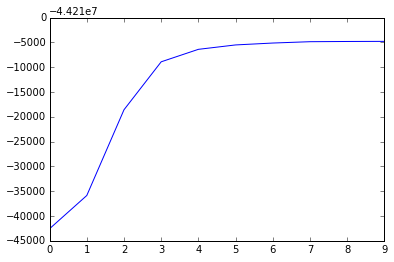

In [11]:
plt.plot(result[3])

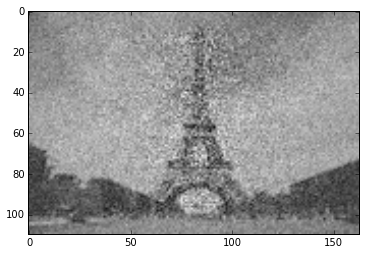

In [7]:
plt.imshow(result[1], cmap='gray')

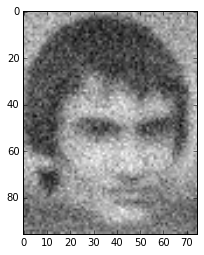

In [13]:
plt.imshow(result[0], cmap='gray')

In [14]:
mean = data.sum(axis=2) / 400

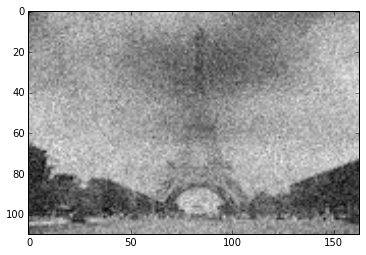

In [15]:
plt.imshow(mean, cmap='gray')

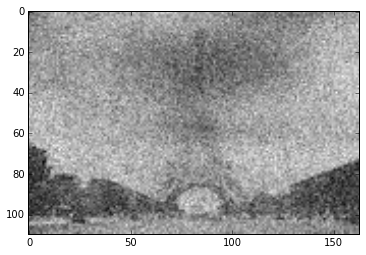

In [16]:
plt.imshow(data[:,:,0:200].sum(axis=2) / 400, cmap='gray')

In [ ]:
plt.imsave('background.png',mean,cmap='gray')